In [1]:
%matplotlib inline
from __future__ import print_function, unicode_literals
import sys, os
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from functools import partial

In [2]:
from pygaarst import raster
import pandas as pd
import geopandas as gp
from fiona.crs import from_string
import shapely.ops
from shapely.geometry import Point, box
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [4]:
sys.path.append('../firedetection/')
import landsat8fire as lfire

In [5]:
sns.set(rc={'image.cmap': 'gist_heat'})
sns.set(rc={'image.cmap': 'bone'})

sns.set_context("poster")

myfontsize = 20
font = {'family' : 'Calibri',
        'weight': 'bold',
        'size'   : myfontsize}
matplotlib.rc('font', **font)
matplotlib.axes.rcParams['axes.labelsize']=myfontsize-4
matplotlib.axes.rcParams['axes.titlesize']=myfontsize
cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'red']))
cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'neon green']))
cmap3 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'orange']))

In [6]:
side = 375.0
def makebox(point, a=100.0, b=None):
    if not b: 
        b=a
    return box((point.x)-a/2, point.y-b/2, point.x+a/2, point.y+b/2)

makeboxes = partial(makebox, a=side)

In [7]:
productdir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/rasterout/'

In [8]:
gisdir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/10_intermediate_products/"

## Eagle data

In [9]:
newviirspolydf = gp.GeoDataFrame.from_file(os.path.join(gisdir, 'EAGLEviirsspoly.shp'))

In [10]:
landsatpath = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/Landsat/L8 OLI_TIRS Eagle/'
lssceneE = 'LC8065014_15_2015147_clip'
landsatE = raster.Landsatscene(os.path.join(landsatpath, lssceneE))

In [11]:
landsatE.meta['PRODUCT_METADATA']['DATE_ACQUIRED'], landsatE.meta['PRODUCT_METADATA']['SCENE_CENTER_TIME']

(datetime.date(2015, 5, 27), datetime.time(20, 47, 22, 205191))

In [12]:
crs = from_string(landsatE.band7.proj4)
samplerecords = newviirspolydf[
    (newviirspolydf['DATE'] == '2015-05-27')
    & (newviirspolydf['GMT'] == '2045')
    & (newviirspolydf['LAT'] < 65.2)
    & (newviirspolydf['LAT'] > 64.8)]
firepolygons_hE = samplerecords[(samplerecords['Type'] != 'L')]['geometry'].to_crs(crs)
firepolygons_lE = samplerecords[(samplerecords['Type'] == 'L')]['geometry'].to_crs(crs)

In [13]:
xmaxE = landsatE.band7.ncol
ymaxE = landsatE.band7.nrow

In [14]:
allfireE, highfireE, anomfireE, lowfireE = lfire.get_l8fire(landsatE, debug=True)

allfire_maskedE = np.ma.masked_where(
        ~allfireE, np.ones((ymaxE, xmaxE)))
highfire_maskedE = np.ma.masked_where(
        ~highfireE, np.ones((ymaxE, xmaxE)))

Getting Landsat 8 reflectances
Getting unambiguous fires
There are 183 unambiguous fires
Getting anomalous fires
There are 0 anomalous fires
Getting candidates for marginal fires
Verifying 102 candidates for marginal fires
Generating mask of valid pixel to validate 102 marginal candidates
Starting loop through candidate locations.
. . . . . . . . . 10% . . . . . . . . . 20% . . . . . . . . . 30% . . . . . . . . . 40% . . . . . . . . . 50% . . . . . . . . . 60% . . . . . . . . . 70% . . . . . . . . . 80% . . . . . . . . . 90% . . . . . . . . . 100% 

In [15]:
print(sum(sum(lowfireE)))
print(sum(sum(allfireE)))

91
274


In [16]:
rgb753sceneE = raster.GeoTIFF(os.path.join(landsatpath, lssceneE, 'LC8065014_15_2015147_clip_fc753_8bit.tif'))
rgb753E = np.rollaxis(rgb753sceneE.data, 0, 3)

In [17]:
wsfirehotspots = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS_I_WS_NASA/Alaska/fires.2015147.2042.txt"
inputframe = pd.read_csv(wsfirehotspots)
inputframe.columns = [colname.strip() for colname in inputframe.columns]

In [18]:
viirsI = inputframe[
    (inputframe['Lat'] < 65.2) 
    & (inputframe['Lat'] > 64.8) 
    & (inputframe['Lon'] < -141)]
viirsI

VIIRS_Granule           Scan_Time        Lon       Lat  Sample  Line  \
337   2015147.2042   20150527_20:46:16 -141.39447  64.89154    4463  4629   
338   2015147.2042   20150527_20:46:16 -141.39963  64.89504    4463  4630   
339   2015147.2042   20150527_20:46:16 -141.39200  64.89713    4462  4630   
340   2015147.2042   20150527_20:46:16 -141.39636  64.90083    4462  4631   
341   2015147.2042   20150527_20:46:16 -141.40428  64.89867    4463  4631   
342   2015147.2042   20150527_20:46:19 -141.62572  65.10587    4452  4698   
343   2015147.2042   20150527_20:46:19 -141.63231  65.10407    4453  4698   

     BT_I4(K)  BT_I5(K)   Confidence   Period    FRP  
337     367.0     305.0      nominal      day  22.29  
338     367.0     297.1      nominal      day   9.41  
339     342.0     293.7      nominal      day   9.41  
340     339.6     294.0      nominal      day   9.41  
341     341.0     294.1      nominal      day   9.41  
342     327.0     290.3      nominal      day   2.92  
343     335.1     292.5      nominal      day   2.92

In [19]:
viirsgeo = viirsI.apply(lambda row: Point(row['Lon'], row['Lat']),
                                    axis='columns')


In [20]:
viirsIDFE = gp.GeoDataFrame(viirsI, 
                           geometry=viirsgeo,
                           crs={'init': 'epsg:4326'} )
viirsIDFE = viirsIDFE.to_crs(crs)

## Sockeye loading

In [29]:
newviirspolydf = gp.GeoDataFrame.from_file(os.path.join(gisdir, 'sockeyeviirsspoly.shp'))

In [30]:
landsatpath = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/Landsat/L8 OLI_TIRS Sockeye'
lsscene = 'LC80700172015166LGN00'
landsat = raster.Landsatscene(os.path.join(landsatpath, lsscene))

In [31]:
landsat.meta['PRODUCT_METADATA']['DATE_ACQUIRED'], landsatE.meta['PRODUCT_METADATA']['SCENE_CENTER_TIME']

(datetime.date(2015, 6, 15), datetime.time(20, 47, 22, 205191))

In [32]:
crs = from_string(landsatE.band7.proj4)
samplerecords = newviirspolydf[
    (newviirspolydf['DATE'] == '2015-06-15') & 
    (newviirspolydf['GMT'] == '2128')]
firepolygons_hS = samplerecords[(samplerecords['Type'] != 'L')]['geometry'].to_crs(crs)
firepolygons_lS = samplerecords[(samplerecords['Type'] == 'L')]['geometry'].to_crs(crs)

In [33]:
xmaxS = landsat.band7.ncol
ymaxS = landsat.band7.nrow

In [ ]:
allfireS, highfireS, anomfireS, lowfireS = lfire.get_l8fire(landsat, debug=True)

allfire_maskedS = np.ma.masked_where(
        ~allfireS, np.ones((ymaxS, xmaxS)))
highfire_maskedS = np.ma.masked_where(
        ~highfireS, np.ones((ymaxS, xmaxS)))

Getting Landsat 8 reflectances
Getting unambiguous fires
There are -- unambiguous fires
Getting anomalous fires
There are 1 anomalous fires
Getting candidates for marginal fires
Verifying -- candidates for marginal fires
Generating mask of valid pixel to validate -- marginal candidates


In [ ]:
rgb753scene = raster.GeoTIFF(os.path.join(landsatpath, lsscene, 'LC80700172015166LGN00_fc753_8bit_clip.tif'))
rgb753S = np.rollaxis(rgb753scene.data, 0, 3)

In [ ]:
wsfirehotspots = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS_I_WS_NASA/Alaska/fires.2015166.2124.txt"
inputframe = pd.read_csv(wsfirehotspots)
inputframe.columns = [colname.strip() for colname in inputframe.columns]
viirsI = inputframe[
    (inputframe['Lat'] < 62.53) 
    & (inputframe['Lat'] > 60.32) 
    & (inputframe['Lon'] > -153.87)
    & (inputframe['Lon'] < -149.15)]
viirsI

## Plots

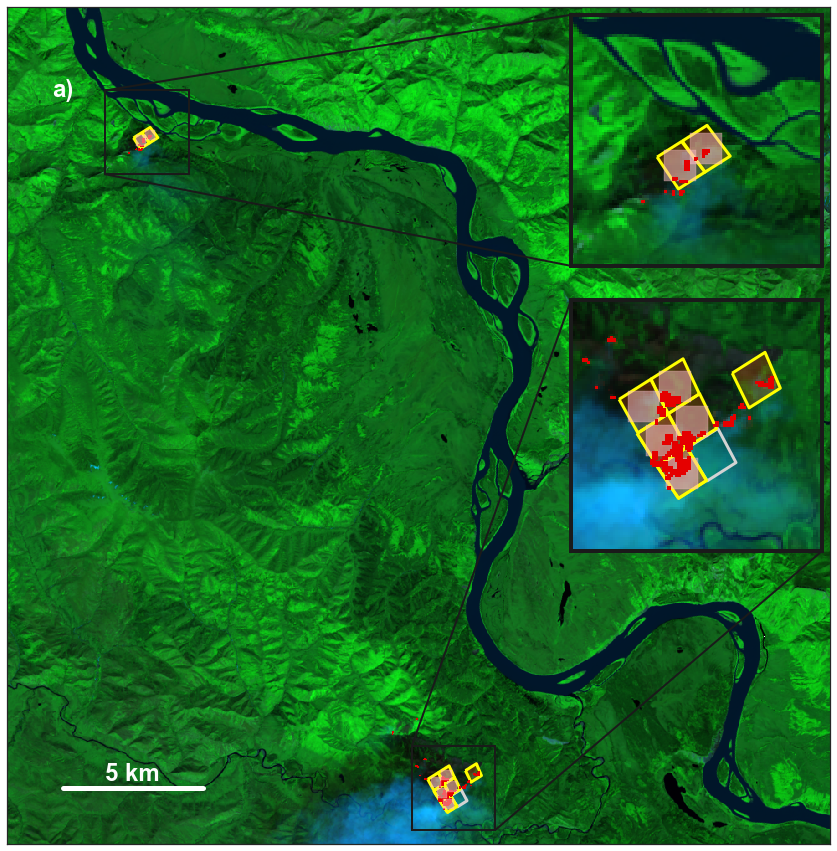

In [28]:
sns.set_style('white')

boxseries = gp.GeoSeries(map(makeboxes, viirsIDFE.geometry.values))
landsat = landsatE
rgb753 = rgb753E
firepolygons_l = firepolygons_lE
firepolygons_h = firepolygons_hE


fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')
X, Y =  landsat.band5._XY
Y = np.flipud(Y)
ax1.set_xlim((X[0][0], X[0, -1]))
ax1.set_ylim((Y[0][0], Y[-1, 0]))
ax1.set_xlim((465500, 495000))
ax1.set_ylim((7225000 , 7195000))
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.invert_yaxis()
#ax1.set_title("High (yellow) and low (grey) intensity VIIRS fire detections over Landsat (red)")
dataplot = ax1.imshow(np.flipud(rgb753), extent=[X[0][0], X[0, -1], Y[0][0], Y[-1, 0]], interpolation='none')
patches1 = [PolygonPatch(poly, facecolor=(0, 0.55, 0.45, 0.25), edgecolor='lightgrey', lw=3) for poly in firepolygons_l]
ax1.add_collection(PatchCollection(patches1, match_original=True))
patches2 = [PolygonPatch(poly, facecolor=(1, 0.35, 0, 0.25), edgecolor='yellow', lw=3) for poly in firepolygons_h]
ax1.add_collection(PatchCollection(patches2, match_original=True))
maskplot1 = ax1.pcolormesh(X, Y, allfire_maskedE, cmap=cmap1, vmin=0, vmax=1)
#scale bar
ax1.plot([467500, 472500], [7197000, 7197000], color='w', lw=5)
ax1.text(470000, 7197500, 
         '5 km', 
          ha="center", va="center", 
          color='w', size=24)
ax1.text(467500, 7222000, 
         'a)', 
          ha="center", va="center", 
          color='w', size=24)

patches3 = [PolygonPatch(poly, color='pink', alpha=0.5) for poly in boxseries]
ax1.add_collection(PatchCollection(patches3, match_original=True))


x1, x2, y1, y2 = 480000, 483000, 7195500, 7198500
axins1 = zoomed_inset_axes(ax1, 3, loc=5)
axins1.imshow(np.flipud(rgb753), extent=[X[0][0], X[0, -1], Y[0][0], Y[-1, 0]], interpolation='none')
axins1.add_collection(PatchCollection(patches1, match_original=True))
axins1.add_collection(PatchCollection(patches2, match_original=True))
axins1.add_collection(PatchCollection(patches3, match_original=True))
axins1.pcolormesh(X, Y, allfire_maskedE, cmap=cmap1, vmin=0, vmax=1, zorder=10)
axins1.set_xlim((x1, x2))
axins1.set_ylim((y1, y2))
axins1.set_xticklabels([])
axins1.set_yticklabels([])
mark_inset(ax1, axins1, loc1=2, loc2=4, fc='none', ec='0.1', lw=2)

x1, x2, y1, y2 = 469000, 472000, 7219000, 7222000
axins3 = zoomed_inset_axes(ax1, 3, loc=1)
axins3.imshow(np.flipud(rgb753), extent=[X[0][0], X[0, -1], Y[0][0], Y[-1, 0]], interpolation='none')
axins3.add_collection(PatchCollection(patches1, match_original=True))
axins3.add_collection(PatchCollection(patches2, match_original=True))
axins3.add_collection(PatchCollection(patches3, match_original=True))
axins3.pcolormesh(X, Y, allfire_maskedE, cmap=cmap1, vmin=0, vmax=1)
axins3.set_xlim((x1, x2))
axins3.set_ylim((y1, y2))
axins3.set_xticklabels([])
axins3.set_yticklabels([])
mark_inset(ax1, axins3, loc1=2, loc2=3, fc='none', ec='0.1', lw=2)

for axis in ['top', 'bottom', 'left', 'right']:
    for ax in axins1, axins3:
        ax.spines[axis].set_color('0.1')
        ax.spines[axis].set_linewidth(4)


In [29]:
outfn = 'Fig08a.png'
fig1.savefig(os.path.join(productdir, outfn), dpi=300, bb_inches='tight')

Helper function

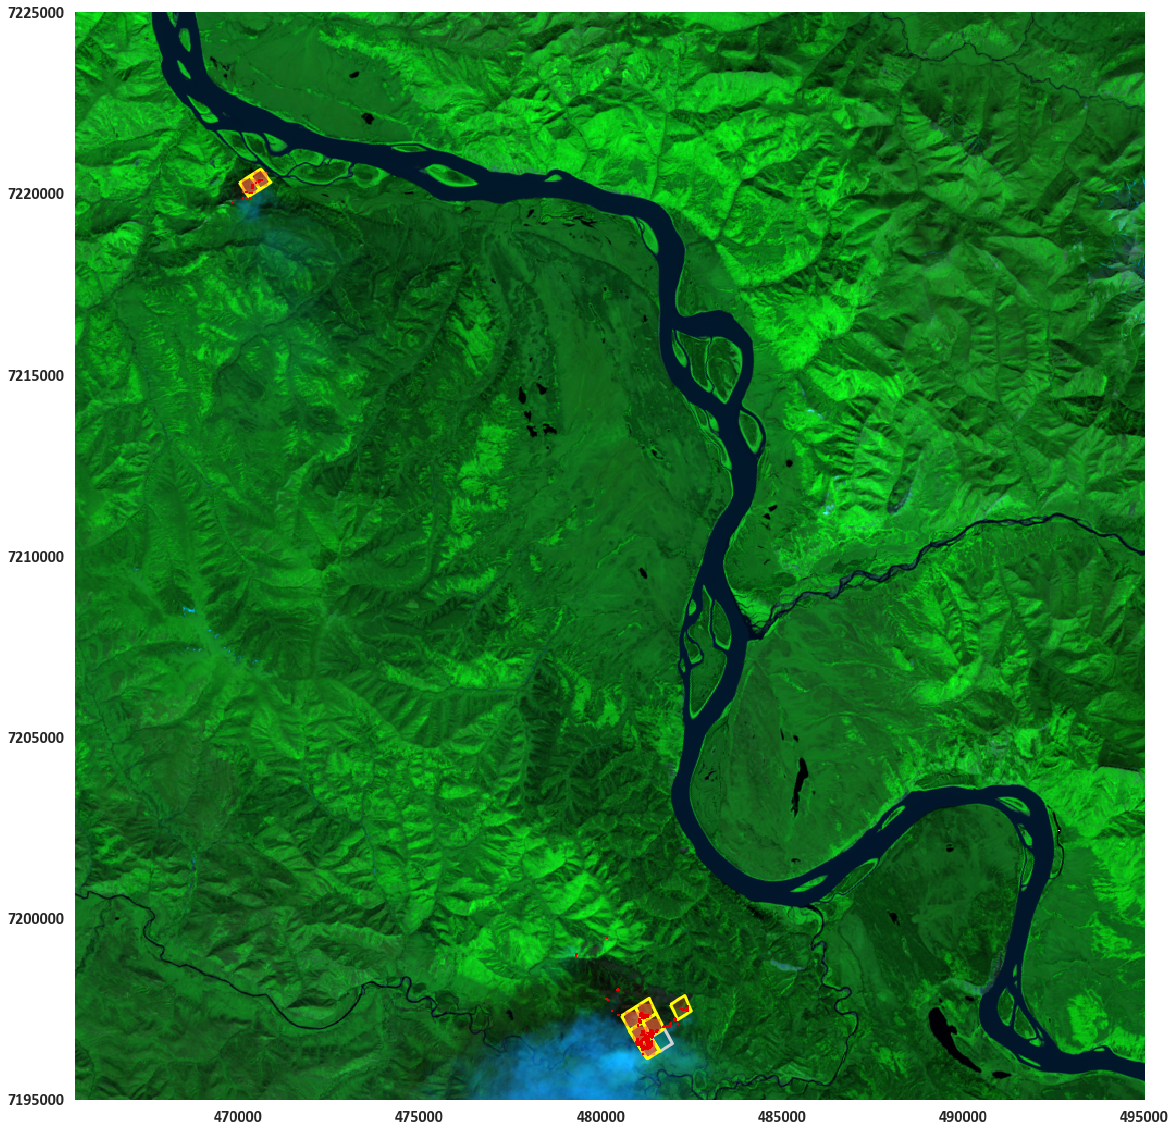

In [60]:
fig1 = plt.figure(1, figsize=(25, 20))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')
X, Y =  landsat.band5._XY
Y = np.flipud(Y)
ax1.set_xlim((X[0][0], X[0, -1]))
ax1.set_ylim((Y[0][0], Y[-1, 0]))
ax1.set_xlim((465500, 495000))
ax1.set_ylim((7225000 , 7195000))
ax1.invert_yaxis()
#ax1.set_title("High (yellow) and low (grey) intensity VIIRS fire detections over Landsat (red)")
dataplot = ax1.imshow(np.flipud(rgb753), extent=[X[0][0], X[0, -1], Y[0][0], Y[-1, 0]], interpolation='none')
patches = [PolygonPatch(poly, facecolor=(0, 0.55, 0.45, 0.25), edgecolor='lightgrey', lw=3) for poly in firepolygons_l]
ax1.add_collection(PatchCollection(patches, match_original=True))
patches = [PolygonPatch(poly, facecolor=(1, 0.35, 0, 0.25), edgecolor='yellow', lw=3) for poly in firepolygons_h]
ax1.add_collection(PatchCollection(patches, match_original=True))
patches = [PolygonPatch(poly, color='tomato', alpha=0.5) for poly in boxseries]
if patches:
    ax1.add_collection(PatchCollection(patches, match_original=True))
maskplot1 = ax1.pcolormesh(X, Y, allfire_masked, cmap=cmap1, vmin=0, vmax=1)


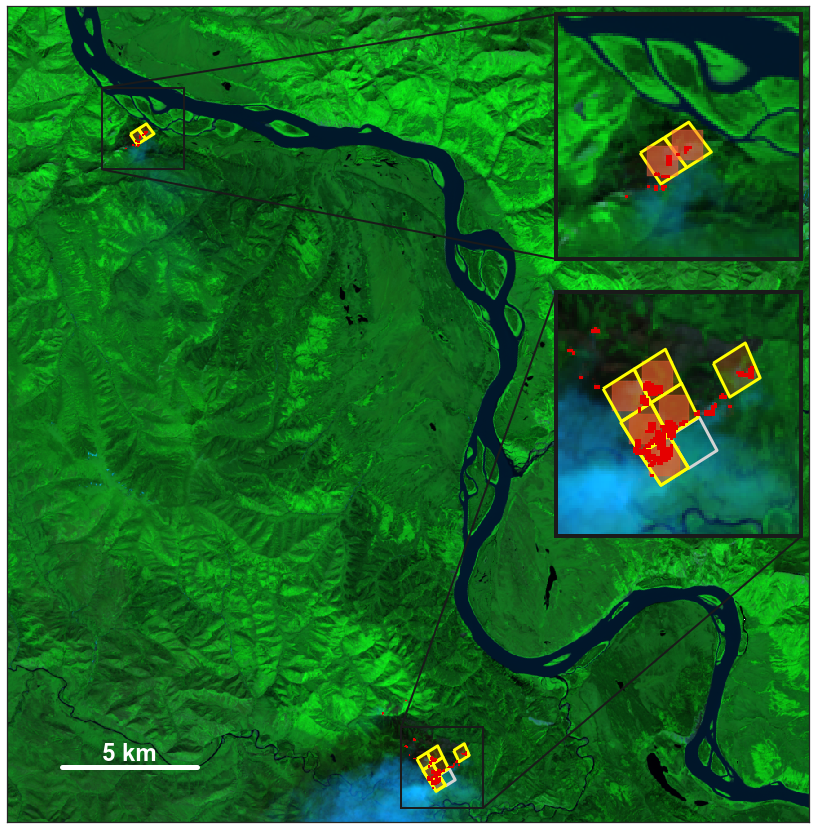

In [70]:
sns.set_style('white')

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')
X, Y =  landsat.band5._XY
Y = np.flipud(Y)
ax1.set_xlim((X[0][0], X[0, -1]))
ax1.set_ylim((Y[0][0], Y[-1, 0]))
ax1.set_xlim((465500, 495000))
ax1.set_ylim((7225000 , 7195000))
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.invert_yaxis()
#ax1.set_title("High (yellow) and low (grey) intensity VIIRS fire detections over Landsat (red)")
dataplot = ax1.imshow(np.flipud(rgb753), extent=[X[0][0], X[0, -1], Y[0][0], Y[-1, 0]], interpolation='none')
patches1 = [PolygonPatch(poly, facecolor=(0, 0.55, 0.45, 0.25), edgecolor='lightgrey', lw=3) for poly in firepolygons_l]
ax1.add_collection(PatchCollection(patches1, match_original=True))
patches2 = [PolygonPatch(poly, facecolor=(1, 0.35, 0, 0.25), edgecolor='yellow', lw=3) for poly in firepolygons_h]
ax1.add_collection(PatchCollection(patches2, match_original=True))
maskplot1 = ax1.pcolormesh(X, Y, allfire_masked, cmap=cmap1, vmin=0, vmax=1)
#scale bar
ax1.plot([467500, 472500], [7197000, 7197000], color='w', lw=5)
ax1.text(470000, 7197500, 
         '5 km', 
          ha="center", va="center", 
          color='w', size=24)

patches3 = [PolygonPatch(poly, color='tomato', alpha=0.5) for poly in boxseries]


x1, x2, y1, y2 = 480000, 483000, 7195500, 7198500
axins1 = zoomed_inset_axes(ax1, 3, loc=5)
axins1.imshow(np.flipud(rgb753), extent=[X[0][0], X[0, -1], Y[0][0], Y[-1, 0]], interpolation='none')
axins1.add_collection(PatchCollection(patches3, match_original=True))
axins1.add_collection(PatchCollection(patches1, match_original=True))
axins1.add_collection(PatchCollection(patches2, match_original=True))
axins1.pcolormesh(X, Y, allfire_masked, cmap=cmap1, vmin=0, vmax=1)
axins1.set_xlim((x1, x2))
axins1.set_ylim((y1, y2))
axins1.set_xticklabels([])
axins1.set_yticklabels([])
mark_inset(ax1, axins1, loc1=2, loc2=4, fc='none', ec='0.1', lw=2)

x1, x2, y1, y2 = 469000, 472000, 7219000, 7222000
axins3 = zoomed_inset_axes(ax1, 3, loc=1)
axins3.imshow(np.flipud(rgb753), extent=[X[0][0], X[0, -1], Y[0][0], Y[-1, 0]], interpolation='none')
axins3.add_collection(PatchCollection(patches2, match_original=True))
axins3.add_collection(PatchCollection(patches1, match_original=True))
axins3.add_collection(PatchCollection(patches3, match_original=True))
axins3.pcolormesh(X, Y, allfire_masked, cmap=cmap1, vmin=0, vmax=1)
axins3.set_xlim((x1, x2))
axins3.set_ylim((y1, y2))
axins3.set_xticklabels([])
axins3.set_yticklabels([])
mark_inset(ax1, axins3, loc1=2, loc2=3, fc='none', ec='0.1', lw=2)

for axis in ['top', 'bottom', 'left', 'right']:
    for ax in axins1, axins3:
        ax.spines[axis].set_color('0.1')
        ax.spines[axis].set_linewidth(4)
